<h1> Steps before Pre-processing to collect final Dataset

1.unziping

In [ ]:
#this code is done on Desktop
import os
import shutil
import multiprocessing

MAIN_PATH = '/Users/dhaneshkumarkapadia/Desktop/Decision making/'

#shutil.unpack_archive(MAIN_PATH + 'Data.zip', MAIN_PATH + 'Data')
shutil.unpack_archive(MAIN_PATH + 'Data/Stress_dataset.zip', MAIN_PATH + 'Data/Stress_dataset')

stress_data_path = MAIN_PATH + '/Data/Stress_dataset'

cpu_count = int(multiprocessing.cpu_count()/2)
print(f'Using {cpu_count} CPUs')

new_list = [
    (file, sub_file)
    for file in os.listdir(stress_data_path)
    for sub_file in os.listdir(os.path.join(stress_data_path, file))
]

def unzip_parallel(file, sub_file):
    shutil.unpack_archive(
        os.path.join(stress_data_path, file, sub_file),
        os.path.join(stress_data_path, file, sub_file[:-4])
    )

pool = multiprocessing.Pool(cpu_count)
results = pool.starmap(unzip_parallel, new_list)
pool.close()

2.Combining all code

In [ ]:
# Script to combine all signals into one

import os
import pandas as pd
from random import randint

DATA_PATH = '/Users/dhaneshkumarkapadia/Desktop/Decision making/stress_dataset'

SAVE_PATH = "data2"
#os.mkdir(SAVE_PATH)

final_columns = {
    'ACC': ['id', 'X', 'Y', 'Z', 'datetime'],
    'EDA': ['id', 'EDA', 'datetime'],
    'HR': ['id', 'HR', 'datetime'],
    'TEMP': ['id', 'TEMP', 'datetime'],
}

names = {
    'ACC.csv': ['X', 'Y', 'Z'],
    'EDA.csv': ['EDA'],
    'HR.csv': ['HR'],
    'TEMP.csv': ['TEMP'],
}

desired_signals = ['ACC.csv', 'EDA.csv', 'HR.csv', 'TEMP.csv']

acc = pd.DataFrame(columns=final_columns['ACC'])
eda = pd.DataFrame(columns=final_columns['EDA'])
hr = pd.DataFrame(columns=final_columns['HR'])
temp = pd.DataFrame(columns=final_columns['TEMP'])


def generate_random_number(length):
    return int(''.join([str(randint(0,10)) for _ in range(length)]))

def process_df(df, sub_file,file):
    start_timestamp = df.iloc[0,0]
    sample_rate = df.iloc[1,0]
    new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
    new_df['id'] = file[-2:]
    new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
    return new_df

for file in os.listdir(DATA_PATH):
    print(f'Processing {file}')
    for sub_file in os.listdir(os.path.join(DATA_PATH, file)):
        if not sub_file.endswith(".zip"):
            for signal in os.listdir(os.path.join(DATA_PATH, file, sub_file)):
                if signal in desired_signals:
                    df = pd.read_csv(os.path.join(DATA_PATH, file, sub_file, signal), names=names[signal], header=None)
                    if not df.empty:
                        if signal == 'ACC.csv':
                            acc = pd.concat([acc, process_df(df, sub_file,file)])
                        if signal == 'EDA.csv':
                            eda = pd.concat([eda, process_df(df, sub_file,file)])
                        if signal == 'HR.csv':
                            hr = pd.concat([hr, process_df(df, sub_file,file)])
                        if signal == 'TEMP.csv':
                            temp = pd.concat([temp, process_df(df, sub_file,file)])

print('Saving Data ...')
acc.to_csv(os.path.join(SAVE_PATH, 'combined_acc.csv'), index=False)
eda.to_csv(os.path.join(SAVE_PATH, 'combined_eda.csv'), index=False)
hr.to_csv(os.path.join(SAVE_PATH, 'combined_hr.csv'), index=False)
temp.to_csv(os.path.join(SAVE_PATH, 'combined_temp.csv'), index=False)

3.Merging Code

In [ ]:
import pandas as pd
import os
import multiprocessing

COMBINED_DATA_PATH = "/content/drive/MyDrive/data2"
SAVE_PATH = "/content/drive/MyDrive/data2/3rdstep1"

if COMBINED_DATA_PATH != SAVE_PATH:
    os.mkdir(SAVE_PATH)

print("Reading data ...")

acc, eda, hr, temp = None, None, None, None

signals = ['acc', 'eda', 'hr', 'temp']

def read_parallel(signal):
    df = pd.read_csv(os.path.join(COMBINED_DATA_PATH, f"combined_{signal}.csv"), dtype={'id': str})
    return [signal, df]

pool = multiprocessing.Pool(len(signals))
results = pool.map(read_parallel, signals)
pool.close()
pool.join()

for i in results:
    globals()[i[0]] = i[1]

# Merge data
print('Merging Data ...')
ids = eda['id'].unique()
columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime']

def merge_parallel(id):
    print(f"Processing {id}")
    df = pd.DataFrame(columns=columns)

    acc_id = acc[acc['id'] == id]
    eda_id = eda[eda['id'] == id].drop(['id'], axis=1)
    hr_id = hr[hr['id'] == id].drop(['id'], axis=1)
    temp_id = temp[temp['id'] == id].drop(['id'], axis=1)

    df = acc_id.merge(eda_id, on='datetime', how='outer')
    df = df.merge(temp_id, on='datetime', how='outer')
    df = df.merge(hr_id, on='datetime', how='outer')

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

pool = multiprocessing.Pool(len(ids))
results = pool.map(merge_parallel, ids)
pool.close()
pool.join()

new_df = pd.concat(results, ignore_index=True)

print("Saving data ...")
new_df.to_csv(os.path.join(SAVE_PATH, "merged_data.csv"), index=False)

Reading data ...
Merging Data ...
Processing 94Processing E4Processing 6BProcessing DFProcessing 5CProcessing 7EProcessing BGProcessing EGProcessing 6DProcessing F5Processing CE
Processing 83

Processing 15

Processing 8BProcessing 7A









Saving data ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


4. final labeling

In [ ]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import os
import multiprocessing

# Read Files
print("Reading 1 ...")
PATH = "/content/drive/MyDrive/data2/3rdstep1"


df = pd.read_csv(os.path.join(PATH, 'merged_data.csv'), dtype={'id': str})
df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda x: x * (10 ** 9)))

print("Reading 2 ...")
survey_path = '/content/drive/MyDrive/data2/SurveyResults.xlsx'

survey_df = pd.read_excel(survey_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_df['Stress level'].replace('na', np.nan, inplace=True)
survey_df.dropna(inplace=True)

survey_df['Start datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['Start time'].map(str))
survey_df['End datetime'] =  pd.to_datetime(survey_df['date'].map(str) + ' ' + survey_df['End time'].map(str))
survey_df.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
print("Converting ...")
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

survey_df1 = survey_df[survey_df['End datetime'] <= daylight].copy()
survey_df1['Start datetime'] = survey_df1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_df1['End datetime'] = survey_df1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_df2 = survey_df.loc[survey_df['End datetime'] > daylight].copy()
survey_df2['Start datetime'] = survey_df2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_df2['End datetime'] = survey_df2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_df = pd.concat([survey_df1, survey_df2], ignore_index=True)
# survey_df = survey_df.loc[survey_df['Stress level'] != 1.0]

survey_df.reset_index(drop=True, inplace=True)

# Label Data
print('Labelling ...')
ids = df['id'].unique()

def parallel(id):
    new_df = pd.DataFrame(columns=['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime', 'label'])

    sdf = df[df['id'] == id].copy()
    survey_sdf = survey_df[survey_df['ID'] == id].copy()

    for _, survey_row in survey_sdf.iterrows():
        ssdf = sdf[(sdf['datetime'] >= survey_row['Start datetime']) & (sdf['datetime'] <= survey_row['End datetime'])].copy()

        if not ssdf.empty:
            ssdf['label'] = np.repeat(survey_row['Stress level'], len(ssdf.index))
            new_df = pd.concat([new_df, ssdf], ignore_index=True)
        else:
            print(f"{survey_row['ID']} is missing label {survey_row['Stress level']} at {survey_row['Start datetime']} to {survey_row['End datetime']}")

    return new_df

pool = multiprocessing.Pool(len(ids))
results = pool.map(parallel, ids)
pool.close()
pool.join()

new_df = pd.concat(results, ignore_index=True)

print('Saving ...')
new_df.to_csv(os.path.join(PATH, 'merged_data_labeled.csv'), index=False)
print('Done')

Reading 1 ...
Reading 2 ...
Converting ...
Labelling ...
6D is missing label 1.0 at 2020-06-03 07:00:00 to 2020-06-03 09:00:00
BG is missing label 0.0 at 2020-11-05 06:15:00 to 2020-11-05 06:17:00
8B is missing label 2.0 at 2020-07-13 16:59:00 to 2020-07-13 17:05:00
EG is missing label 2.0 at 2020-11-08 19:30:00 to 2020-11-08 20:00:00BG is missing label 2.0 at 2020-12-07 00:58:00 to 2020-12-07 01:15:00

BG is missing label 0.0 at 2020-12-07 01:45:00 to 2020-12-07 02:18:00
94 is missing label 1.0 at 2020-05-10 13:06:00 to 2020-05-10 13:38:00
94 is missing label 1.0 at 2020-06-24 18:50:00 to 2020-06-24 19:15:00
94 is missing label 0.0 at 2020-07-07 17:26:00 to 2020-07-07 17:33:00
94 is missing label 0.0 at 2020-07-07 19:47:00 to 2020-07-07 19:53:00
5C is missing label 1.0 at 2020-04-15 13:00:00 to 2020-04-15 14:00:00
E4 is missing label 2.0 at 2020-06-25 23:19:00 to 2020-06-26 00:19:00
5C is missing label 0.0 at 2020-06-12 07:00:00 to 2020-06-12 08:00:00
15 is missing label 2.0 at 2020-0

<h1> Pre-processing

Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('/Users/dhaneshkumarkapadia/Desktop/resit/dm/merged_data_labeled.csv', dtype={'id': str})

In [ ]:
data.shape

(11509051, 9)

In [ ]:
data.head()

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-72.0,68.0,-38.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.000000000,2.0
1,-18.0,74.0,-21.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.031249920,2.0
2,-17.0,69.0,-36.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.062500096,2.0
3,-27.0,57.0,-20.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.093750016,2.0
4,7.0,61.0,1.0,22.903978,90.85,35.73,94,2020-05-10 23:55:00.124999936,2.0


In [ ]:
data.columns

Index(['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'id', 'datetime', 'label'], dtype='object')

In [ ]:
data.dtypes

X           float64
Y           float64
Z           float64
EDA         float64
HR          float64
TEMP        float64
id           object
datetime     object
label       float64
dtype: object

In [ ]:
data['label'].value_counts()

label
2.0    8540583
0.0    2162246
1.0     806222
Name: count, dtype: int64

In [ ]:
data.isnull().sum()

X           0
Y           0
Z           0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
dtype: int64

In [ ]:
data.describe()

,X,Y,Z,EDA,HR,TEMP,label
count,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07
mean,-2.823774e+01,-9.091031e-01,2.382449e+01,3.502127e+00,8.576053e+01,3.223435e+01,1.554202e+00
std,3.142310e+01,3.343382e+01,2.985317e+01,5.656541e+00,1.419601e+01,2.260516e+00,7.891827e-01
min,-1.280000e+02,-1.280000e+02,-1.280000e+02,0.000000e+00,5.100000e+01,2.409000e+01,0.000000e+00
25%,-5.200000e+01,-1.900000e+01,4.000000e+00,2.242060e-01,7.672000e+01,3.019000e+01,1.000000e+00
50%,-3.300000e+01,1.000000e+00,2.500000e+01,1.157407e+00,8.390000e+01,3.257000e+01,2.000000e+00
75%,-1.400000e+01,1.700000e+01,4.900000e+01,4.077436e+00,9.310000e+01,3.425000e+01,2.000000e+00
max,1.270000e+02,1.270000e+02,1.270000e+02,5.976071e+01,1.802300e+02,3.659000e+01,2.000000e+00


In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
data.isnull().sum()


X           0
Y           0
Z           0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   X         float64       
 1   Y         float64       
 2   Z         float64       
 3   EDA       float64       
 4   HR        float64       
 5   TEMP      float64       
 6   id        object        
 7   datetime  datetime64[ns]
 8   label     float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 790.3+ MB


In [ ]:
data['label'].value_counts()

label
2.0    8540583
0.0    2162246
1.0     806222
Name: count, dtype: int64

In [ ]:
# Rename the column named 'label' to 'Stressed'
data = data.rename(columns = {'label':'Stressed'})

# Replace all occurrences of the value 2.0 in the 'Stressed' column with 1.0
data['Stressed'] = data['Stressed'].replace({2.0 : 1.0})

# Count and display the number of occurrences of each unique value in the 'Stressed' column
data['Stressed'].value_counts()

Stressed
1.0    9346805
0.0    2162246
Name: count, dtype: int64

In [ ]:
# Get the unique IDs representing different nurses from the 'id' column of the data
nurses = data['id'].unique()

# Create a new DataFrame with columns for nurse IDs and counts of 'Stressed' and 'Not Stressed' instances
table = pd.DataFrame(columns = ['Nurse id','Stressed', 'Not Stressed'])

# Iterate over each unique nurse ID
for i in range(len(nurses)):
    # Filter the data to only include rows corresponding to the current nurse ID
    a = data[data['id'] ==  nurses[i]]

    # For the current nurse, count the number of 'Stressed' (value 1.0) instances and 'Not Stressed' (value 0.0) instances
    # The 'get' method is used to fetch the count if it exists, or default to 0 if the value doesn't exist for that nurse
    table.loc[i] = [nurses[i], a['Stressed'].value_counts().get(1.0, 0), a['Stressed'].value_counts().get(0.0, 0)]

    #print(nurses[i])
    #print(a['Stressed'].value_counts())


In [ ]:
# Add a new column 'total' to the table which sums the values of 'Stressed' and 'Not Stressed' for each nurse
table['total'] = table['Stressed'] + table['Not Stressed']

# Compute the percentage representation of each nurse's total count against the overall total count of all nurses
# Add this computed percentage as a new column named 'percentage' to the table
table['percentage'] = (table['total']/table['total'].sum())*100

# Display the updated table
table


,Nurse id,Stressed,Not Stressed,total,percentage
0,94,219943,366153,586096,5.092479
1,DF,842886,65282,908168,7.890903
2,F5,504985,30721,535706,4.654650
3,E4,1206681,281190,1487871,12.927834
4,7E,136323,117124,253447,2.202154
5,6B,718027,107522,825549,7.173041
6,5C,556809,309121,865930,7.523904
7,6D,88322,503041,591363,5.138243
8,BG,587533,21122,608655,5.288490
9,EG,549124,0,549124,4.771236


In [ ]:
#dropping the id columns for correlation
data1 = data.drop('id', axis =1)
# Compute the pairwise correlation of columns
data1.corr()

,X,Y,Z,EDA,HR,TEMP,datetime,Stressed
X,1.000000,0.067204,0.197295,0.093888,0.126069,0.022847,0.105651,-0.008911
Y,0.067204,1.000000,0.019083,-0.096138,-0.068198,-0.084576,-0.071118,-0.024060
Z,0.197295,0.019083,1.000000,0.005993,-0.104143,-0.029366,-0.052299,-0.048750
EDA,0.093888,-0.096138,0.005993,1.000000,0.142523,0.352888,-0.105373,0.046890
HR,0.126069,-0.068198,-0.104143,0.142523,1.000000,0.158127,0.043812,-0.028982
TEMP,0.022847,-0.084576,-0.029366,0.352888,0.158127,1.000000,0.180263,0.126855
datetime,0.105651,-0.071118,-0.052299,-0.105373,0.043812,0.180263,1.000000,0.083788
Stressed,-0.008911,-0.024060,-0.048750,0.046890,-0.028982,0.126855,0.083788,1.000000


Skeness

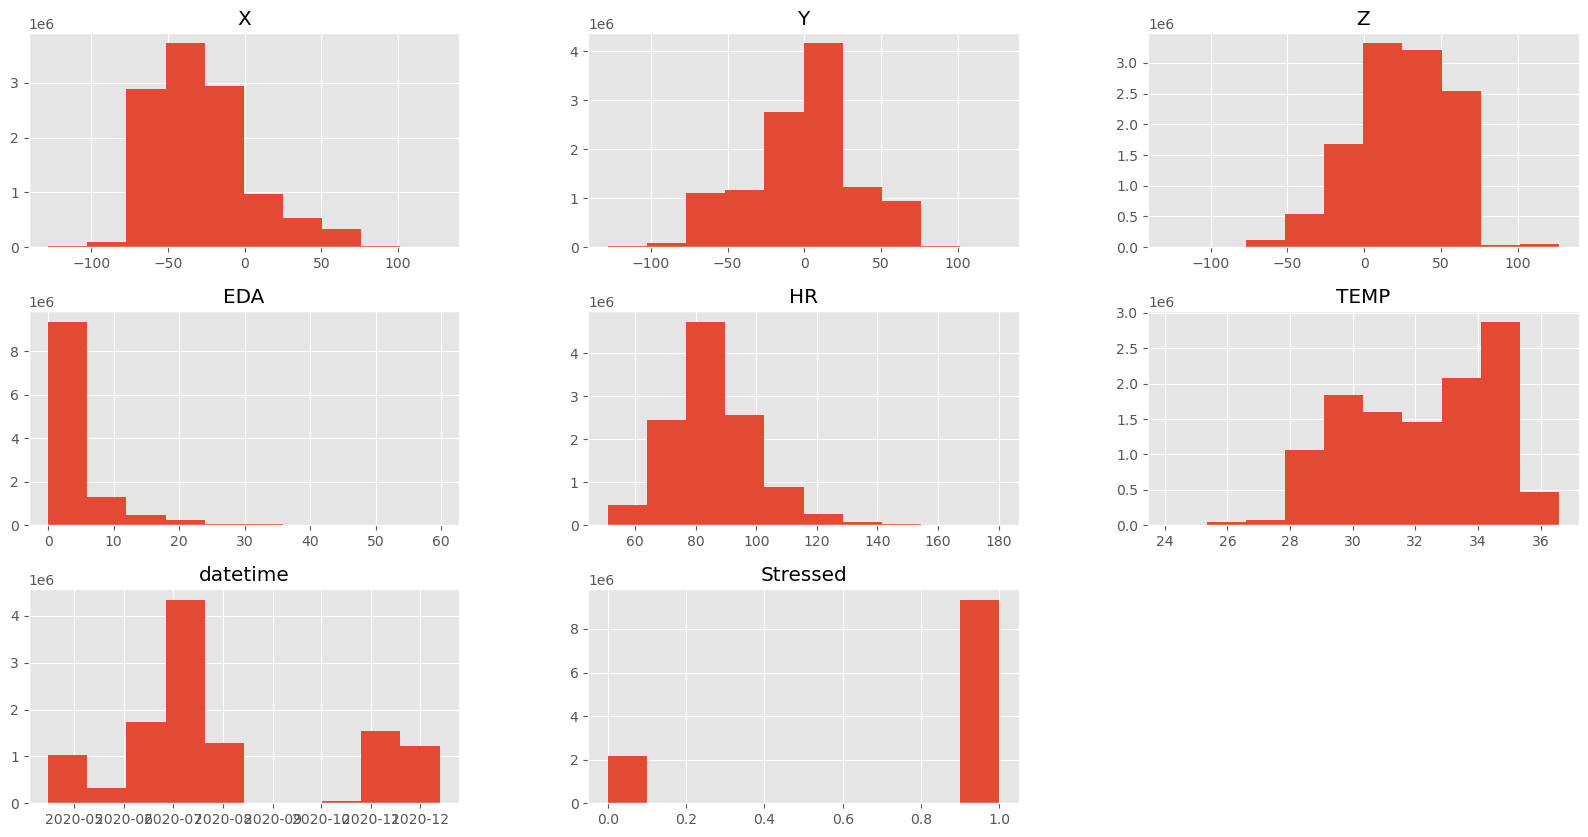

In [ ]:
data.hist(figsize = (20,10))
plt.show()

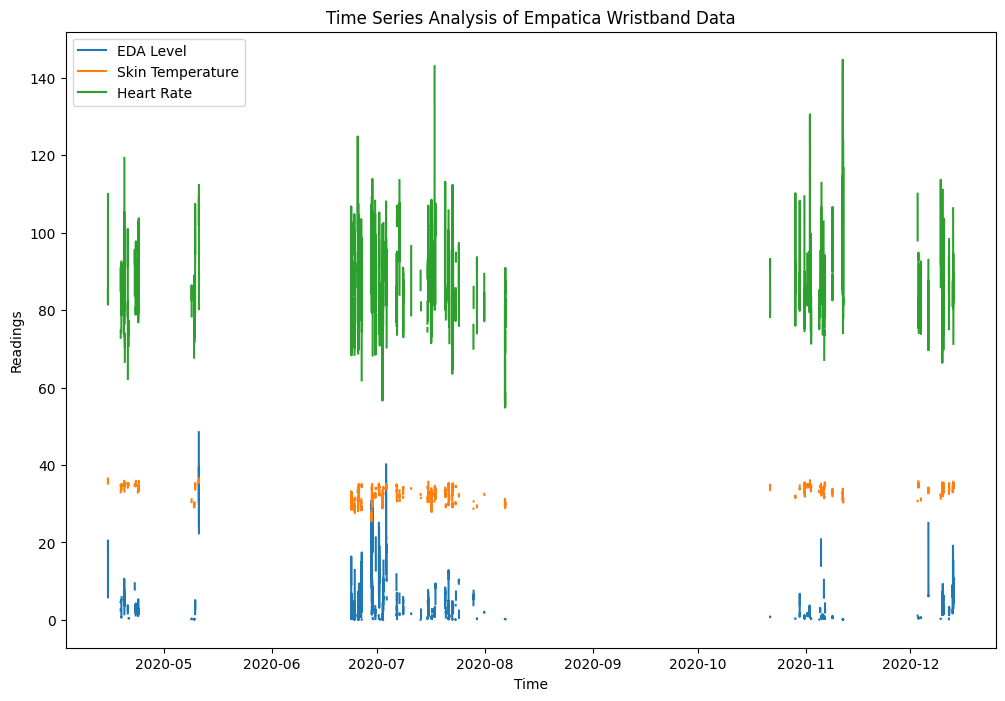

In [ ]:

df = pd.read_csv("/content/drive/MyDrive/data2/3rdstep1/merged_data_labeled.csv", index_col='datetime', parse_dates=['datetime'], dtype={'id': str})

df_resampled = df.resample('5min').mean(numeric_only=True)

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df_resampled.index, df_resampled['EDA'], label='EDA Level')
ax.plot(df_resampled.index, df_resampled['TEMP'], label='Skin Temperature')
ax.plot(df_resampled.index, df_resampled['HR'], label='Heart Rate')

ax.set_xlabel('Time')
ax.set_ylabel('Readings')
ax.set_title('Time Series Analysis of Empatica Wristband Data')
ax.legend()

plt.show()

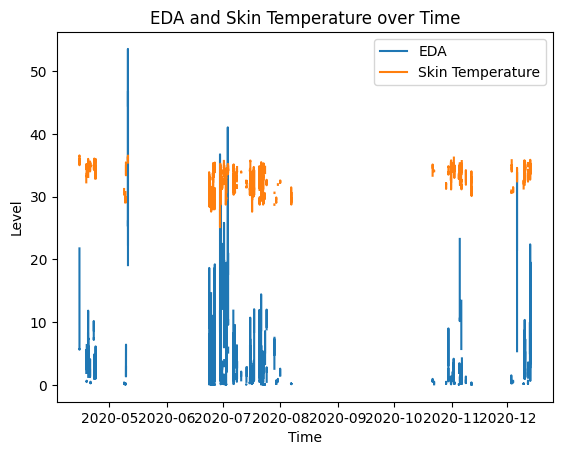

In [ ]:
# Resample the data to 1 minute intervals
df_resampled = df.resample('1T').mean(numeric_only=True)

# Plot the EDA and skin temperature data over time
plt.plot(df_resampled.index, df_resampled['EDA'], label='EDA')
plt.plot(df_resampled.index, df_resampled['TEMP'], label='Skin Temperature')


plt.title('EDA vs Skin')
plt.xlabel('Time')
plt.ylabel('Level')

# Show the legend
plt.legend()

# Display the chart
plt.show()

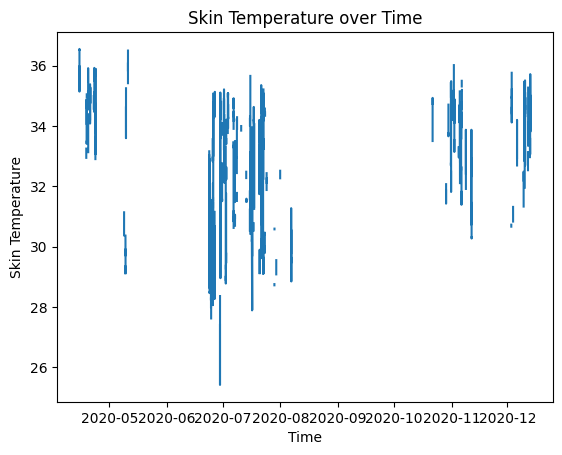

In [ ]:
# Resample the data to 5-minute intervals and calculate the mean for each interval
df_resampled = df.resample('5T').mean(numeric_only=True)

# Create a line chart of the skin temperature over time
plt.plot(df_resampled.index, df_resampled['TEMP'])
plt.xlabel('Time')
plt.ylabel('Skin Temperature')
plt.title('Skin Temperature over Time')
plt.show()

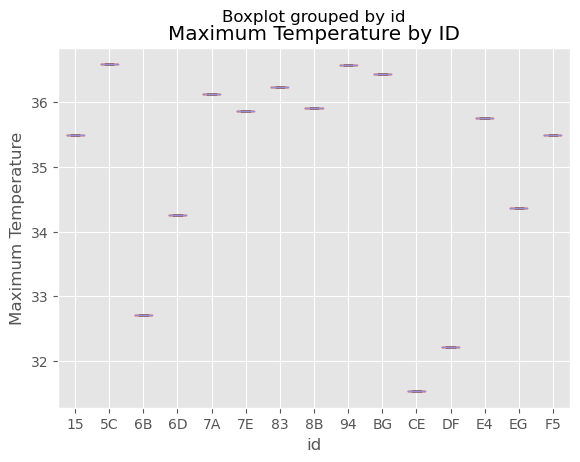

In [ ]:
#groups the data  by the unique values in the "id" column and  returns the maximum "TEMP" value for each group
max_temp = data.loc[data.groupby("id")["TEMP"].idxmax()]
max_temp.boxplot(column="TEMP", by="id")
plt.xlabel("id")
plt.ylabel("Maximum Temperature")
plt.title("Maximum Temperature by ID")
plt.show()

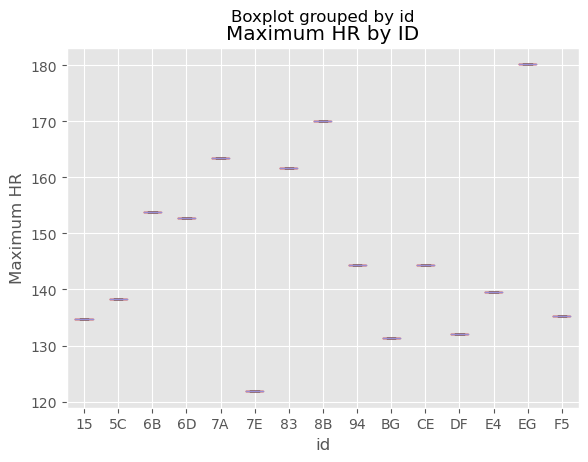

In [ ]:
#groups the data  by the unique values in the "id" column and  returns the maximum "HR" value for each group
max_hr = data.loc[data.groupby("id")["HR"].idxmax()]
ax_hr.boxplot(column="HR", by="id")
plt.xlabel("id")
plt.ylabel("Maximum HR")
plt.title("Maximum HR by ID")
plt.show()

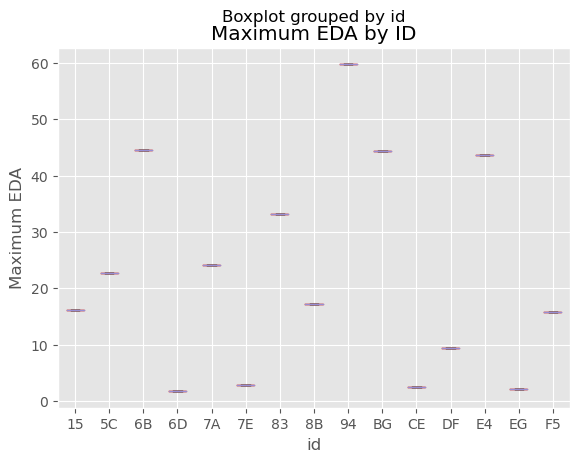

In [ ]:
#groups the data  by the unique values in the "id" column and  returns the maximum "EDA" value for each group
max_eda = data.loc[data.groupby("id")["EDA"].idxmax()]
max_eda.boxplot(column="EDA", by="id")
plt.xlabel("id")
plt.ylabel("Maximum EDA")
plt.title("Maximum EDA by ID")
plt.show()


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


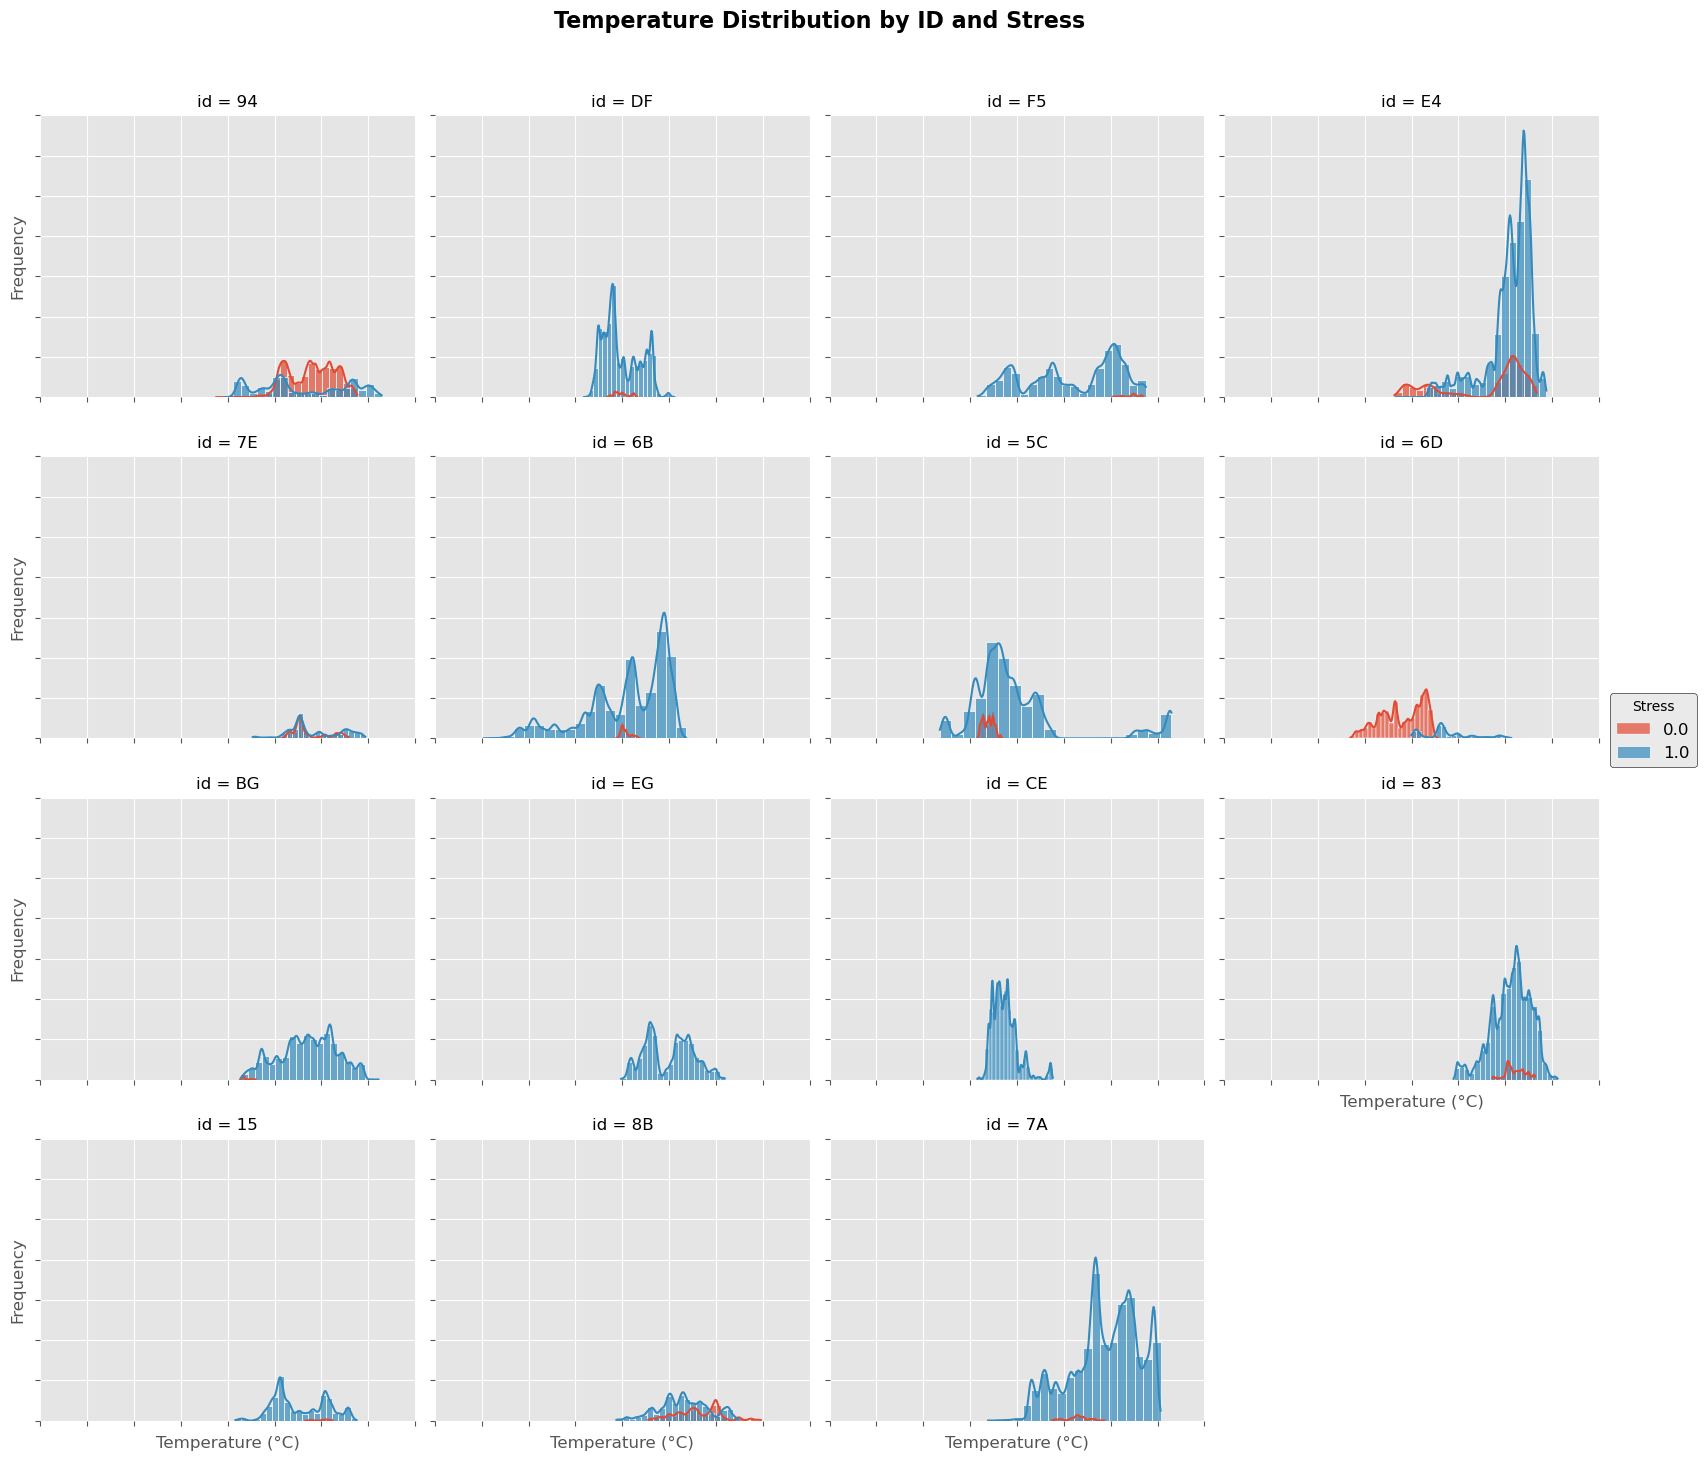

In [ ]:
#For every indivisual nurses facetgrid plot for Temp distribution
g = sns.FacetGrid(data, col="id", hue="Stressed", col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.histplot, "TEMP", bins=20, kde=True, alpha=0.7, edgecolor='white')
g.set_axis_labels("Temp", "Freq")
g.fig.suptitle("Temperature Distribution", y=1.05, fontsize=16, fontweight='bold')
g.add_legend(fontsize=12, title="Stress", title_fontsize=14, frameon=True, edgecolor='black')
g.despine(left=True, bottom=True)
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
plt.show()

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


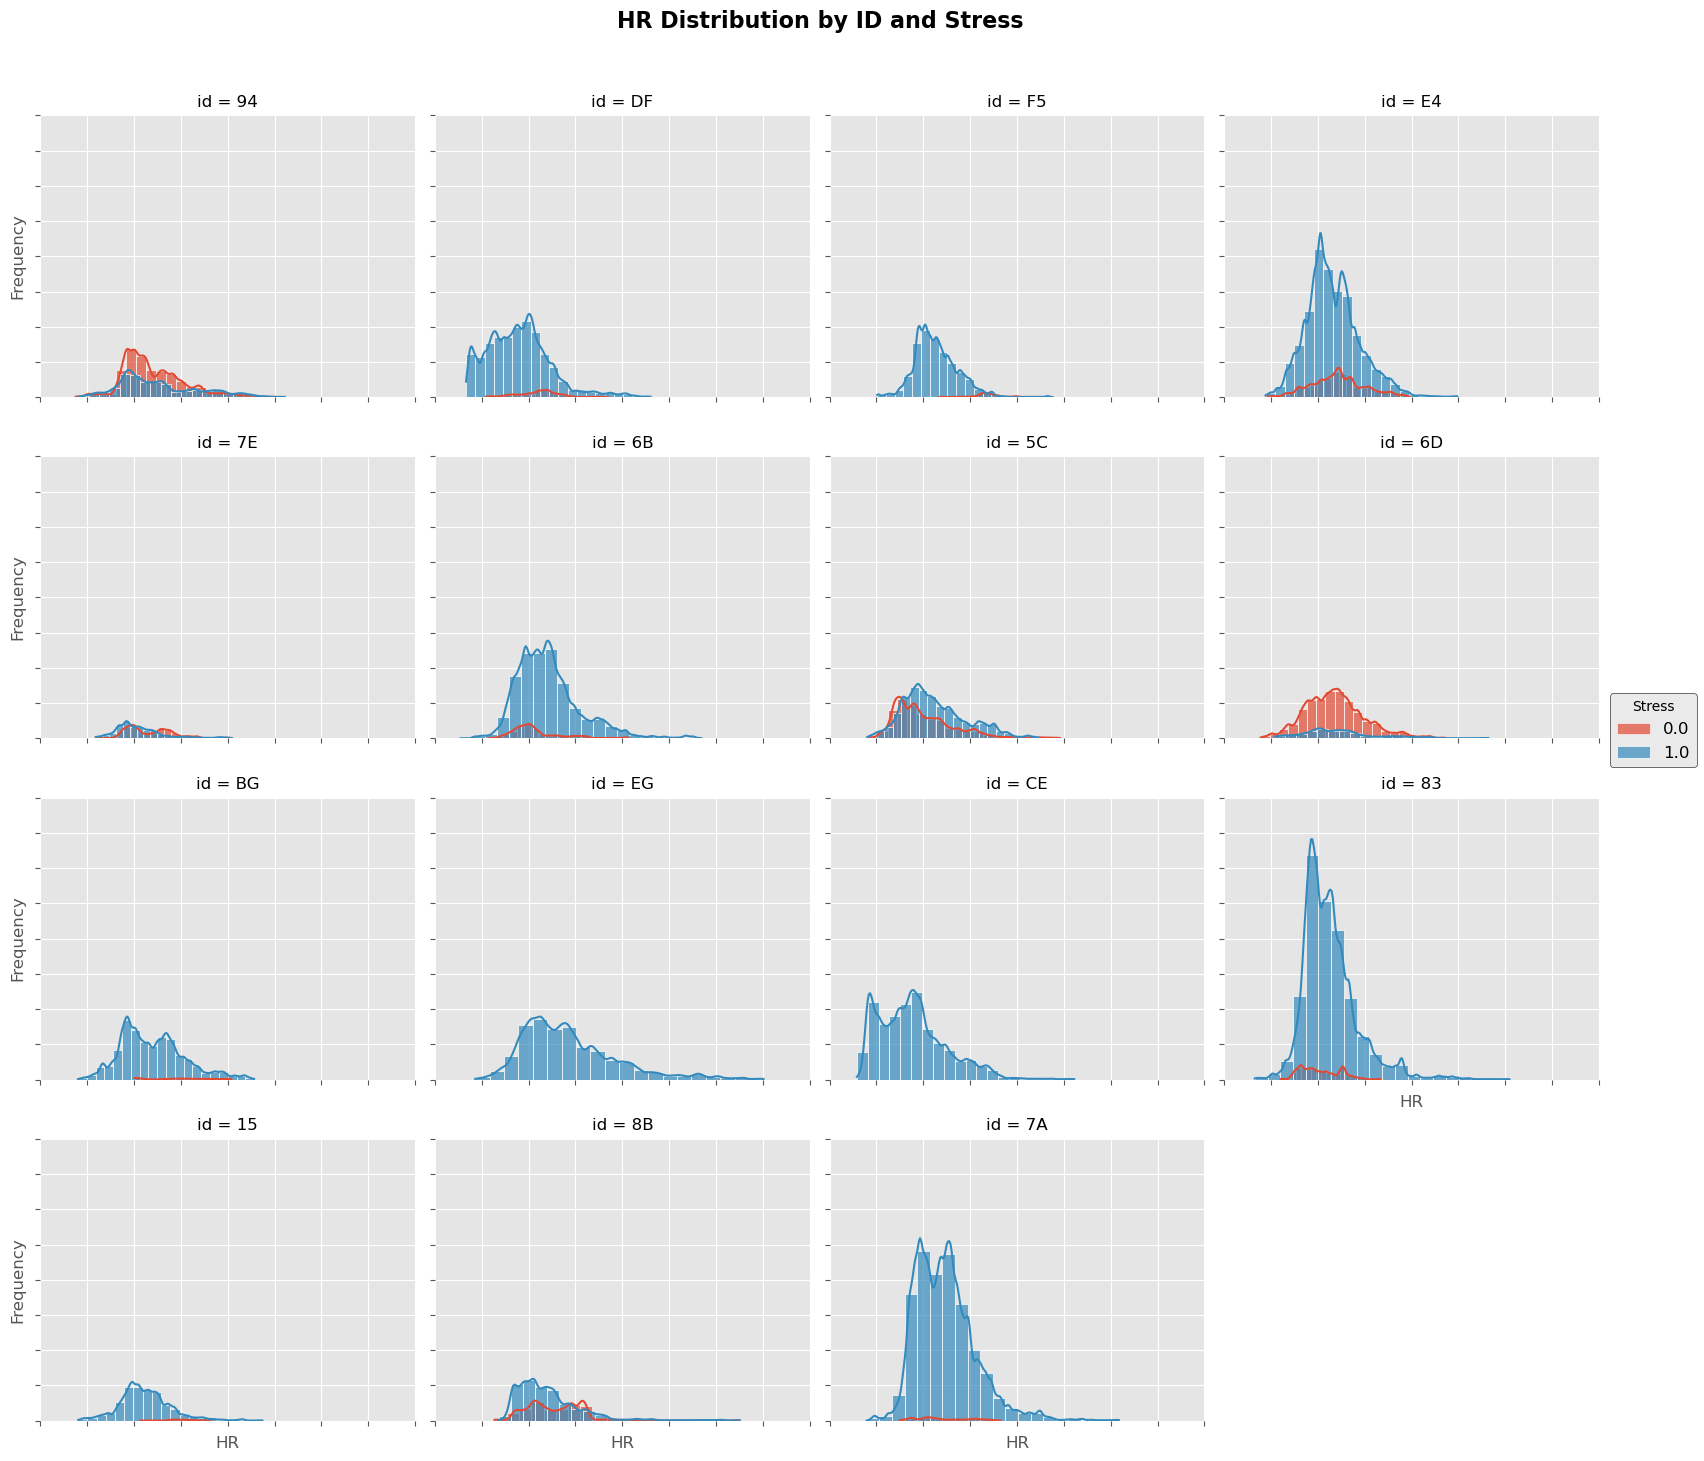

In [ ]:
#For every indivisual nurses facetgrid plot for HR distribution
g = sns.FacetGrid(data, col="id", hue="Stressed", col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.histplot, "HR", bins=20, kde=True, alpha=0.7, edgecolor='white')
g.set_axis_labels("HR", "Freq")
g.fig.suptitle("HR Distribution", y=1.05, fontsize=16, fontweight='bold')
g.add_legend(fontsize=12, title="Stress", title_fontsize=14, frameon=True, edgecolor='black')
g.despine(left=True, bottom=True)
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
plt.show()


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


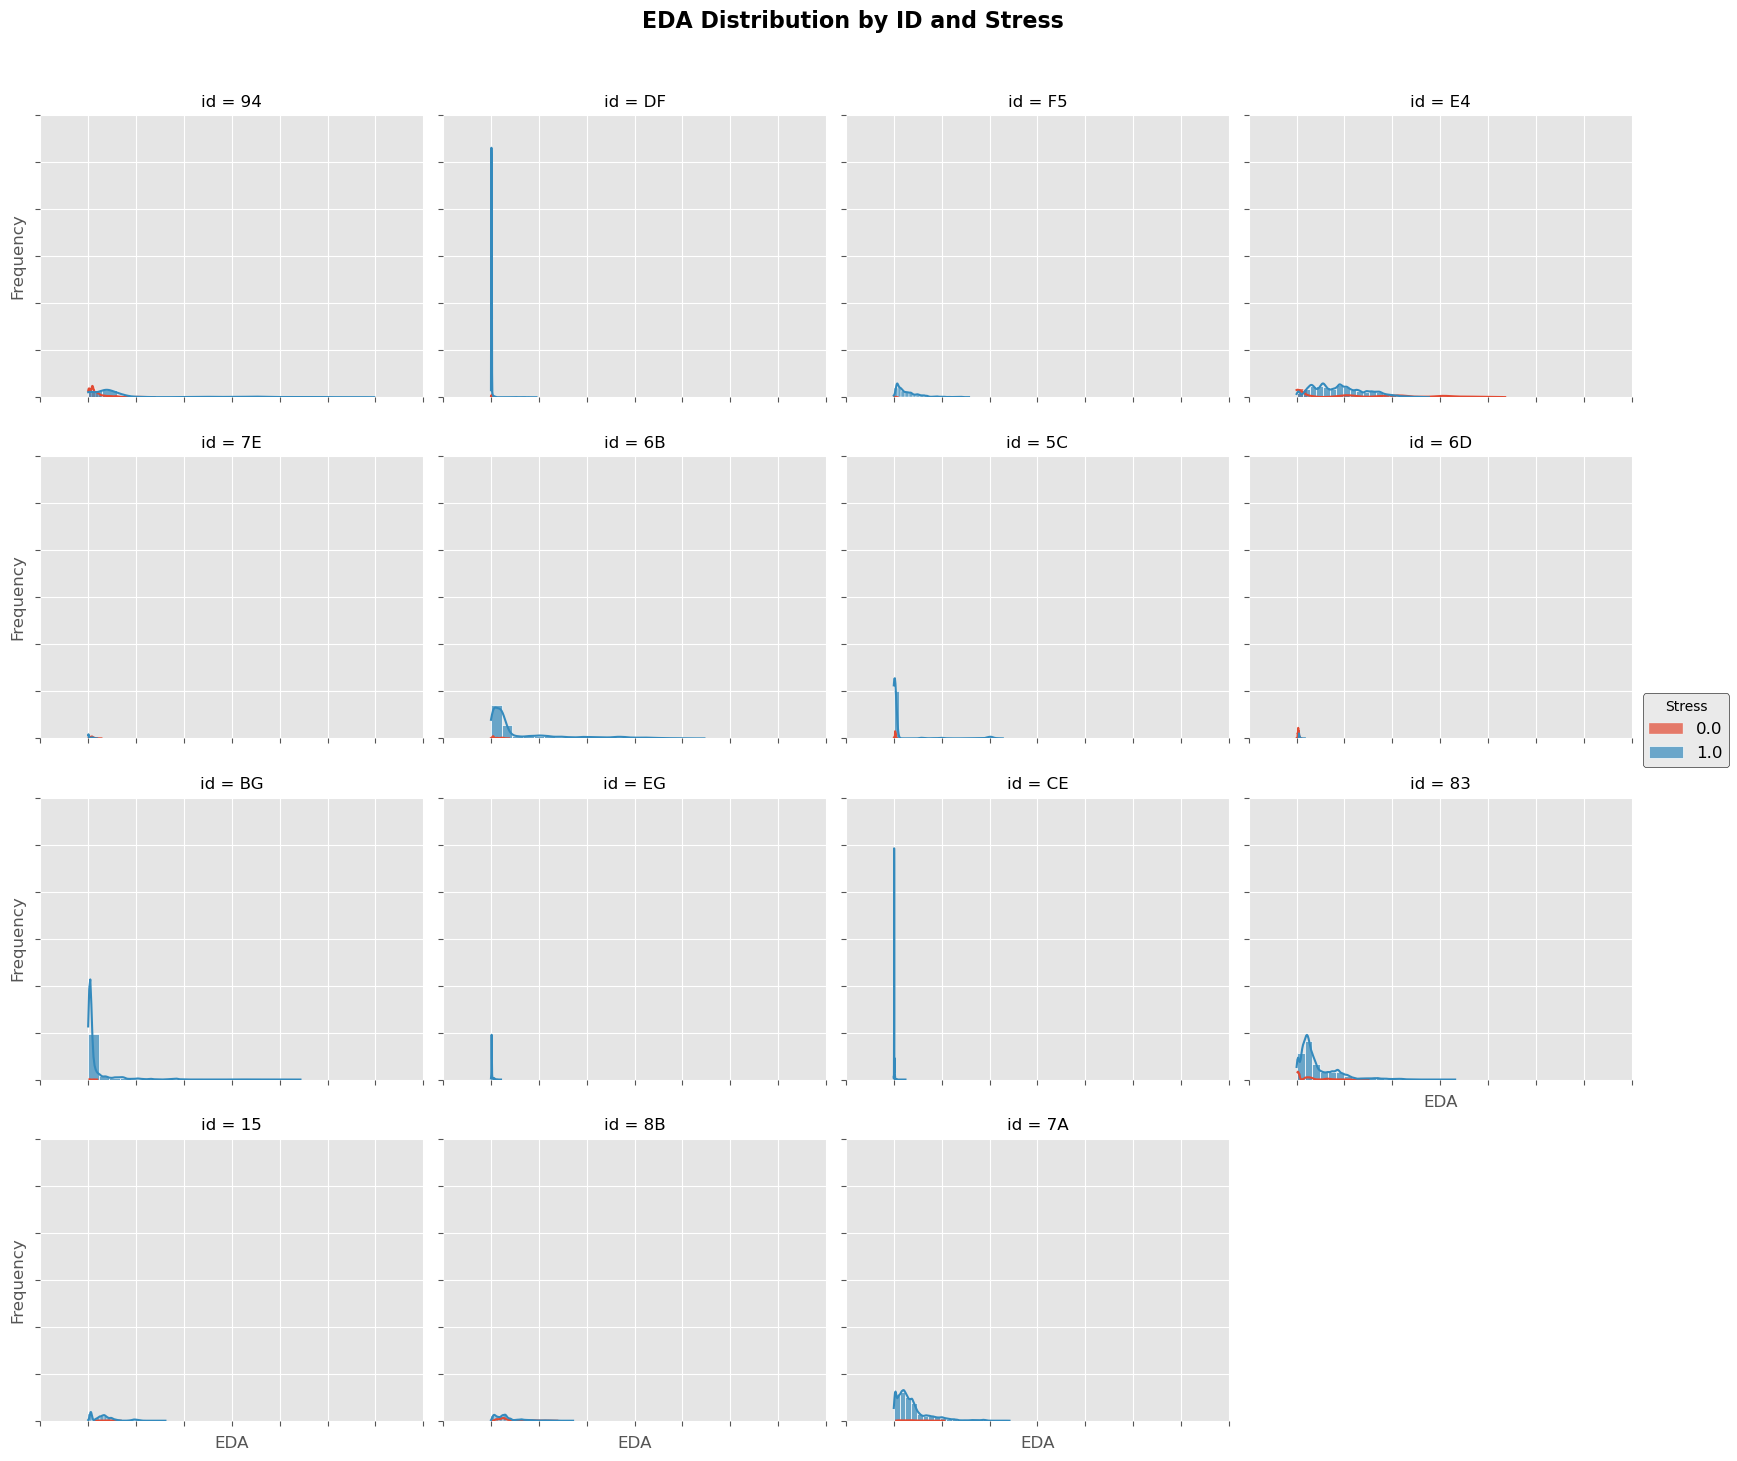

In [ ]:
#For every indivisual nurses facetgrid plot for EDA distribution
g = sns.FacetGrid(data, col="id", hue="Stressed", col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.histplot, "EDA", bins=20, kde=True, alpha=0.7, edgecolor='white')
g.set_axis_labels("EDA", "Freq")
g.fig.suptitle("EDA Distribution", y=1.05, fontsize=16, fontweight='bold')
g.add_legend(fontsize=12, title="Stress", title_fontsize=14, frameon=True, edgecolor='black')
g.despine(left=True, bottom=True)
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
plt.show()

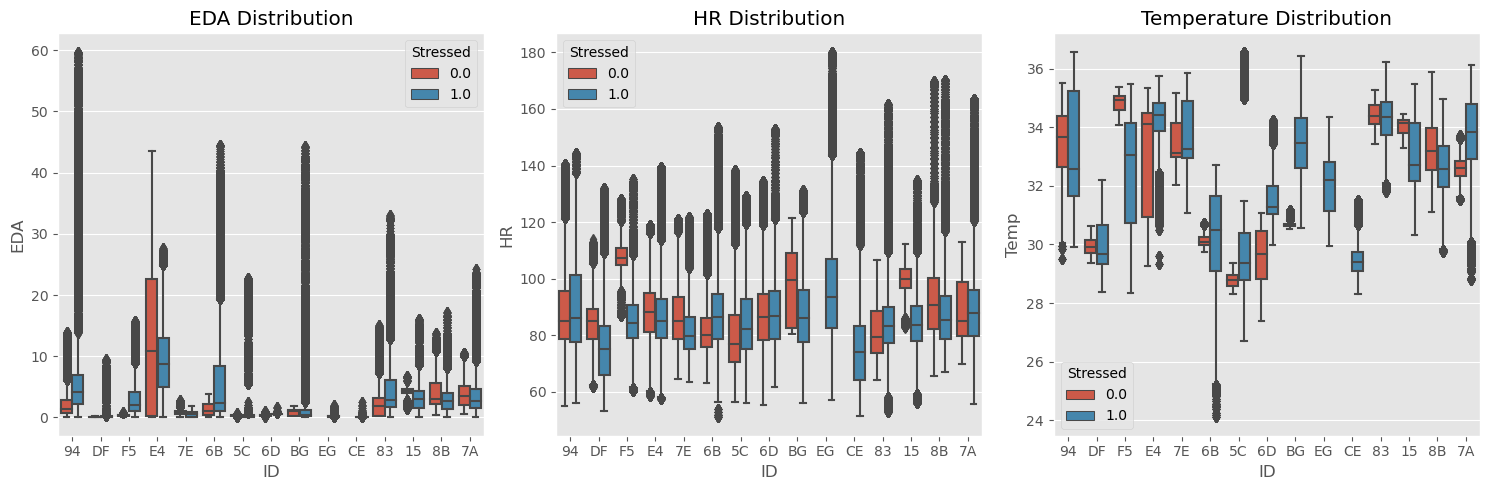

In [ ]:
#outliers
fig, axs = plt.subplots(1, 3, figsize=(15,5))

sns.boxplot(x="id", y="EDA", hue="Stressed", data=data, ax=axs[0])
sns.boxplot(x="id", y="HR", hue="Stressed", data=data, ax=axs[1])
sns.boxplot(x="id", y="TEMP", hue="Stressed", data=data, ax=axs[2])

axs[0].set_xlabel("ID")
axs[0].set_ylabel("EDA")
axs[0].set_title("EDA Distribution")

axs[1].set_xlabel("ID")
axs[1].set_ylabel("HR")
axs[1].set_title("HR Distribution")

axs[2].set_xlabel("ID")
axs[2].set_ylabel("Temp")
axs[2].set_title("Temperature Distribution")

plt.tight_layout()


plt.show()



/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


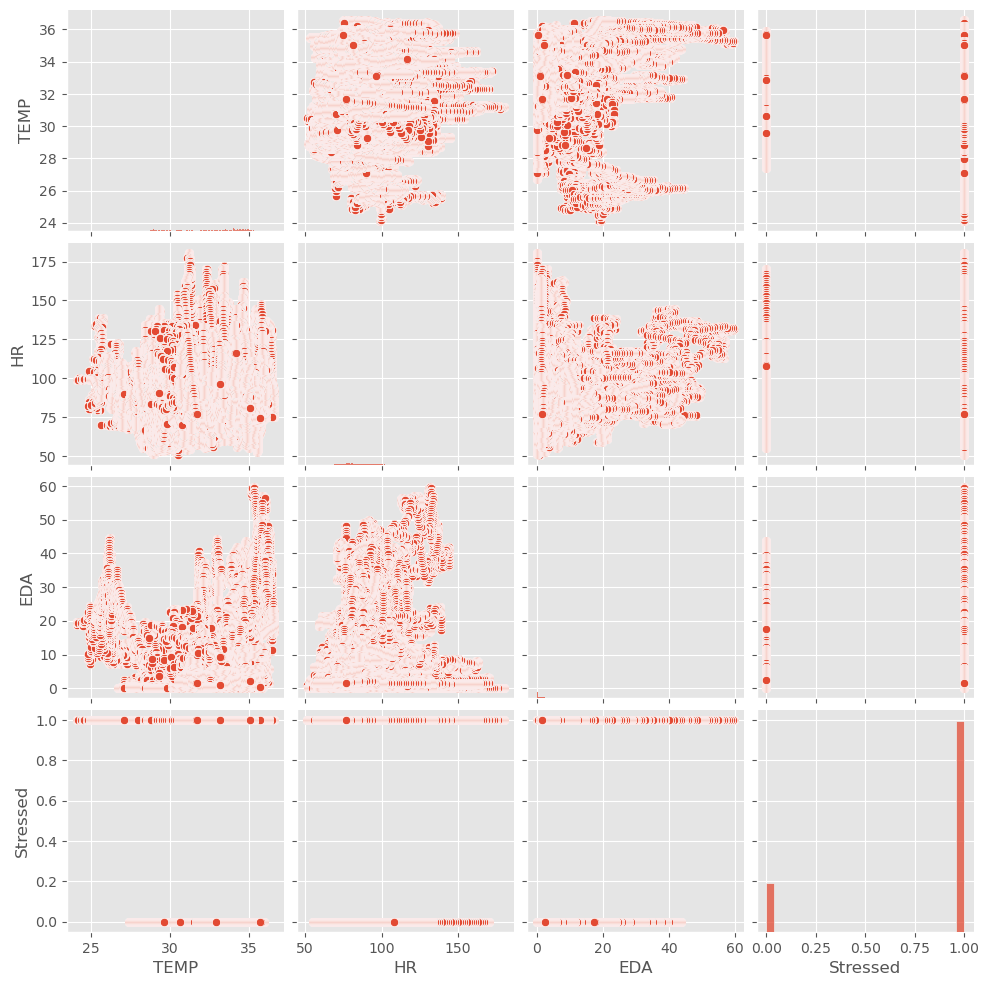

In [ ]:
#pairplot
cols_of_interest = ["TEMP", "HR", "EDA", "Stressed"]
sns.pairplot(data=data[cols_of_interest])

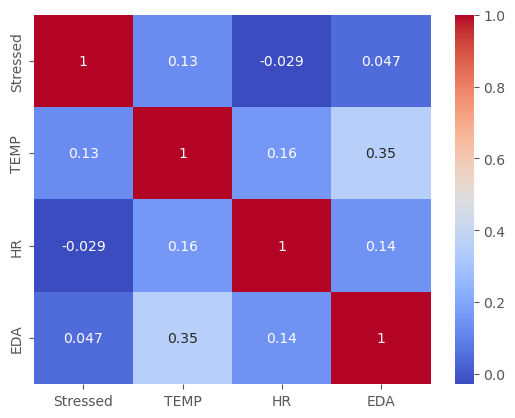

          Stressed      TEMP        HR       EDA
Stressed  1.000000  0.126855 -0.028982  0.046890
TEMP      0.126855  1.000000  0.158127  0.352888
HR       -0.028982  0.158127  1.000000  0.142523
EDA       0.046890  0.352888  0.142523  1.000000


In [ ]:
#heatmap function to visualize the correlation matrix
corr_matrix = data[["Stressed", "TEMP", "HR", "EDA"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()
print(corr_matrix)



Model Training

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split
# Create a scaler instance
scaler = StandardScaler()

X = data[['X', 'Y', 'Z', 'TEMP', 'HR', 'EDA']] # input variables & droping id and timestamp
y = data['Stressed'] # target variable

X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler.fit(X_train_temp)

X_train_stand = scaler.transform(X_train_temp)
X_val_stand = scaler.transform(X_val)
X_test_stand = scaler.transform(X_test)

In [ ]:

print("Training set size:", len(X_train_stand))
print("Validation set size:", len(X_val_stand))
print("Test set size:", len(X_test_stand))


Training set size: 9207240
Validation set size: 1150905
Test set size: 1150906


Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error



clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train_stand, y_train_temp)
y_val_pred = clf.predict(X_val_stand)
accuracy = accuracy_score(y_val, y_val_pred)
print('For Validation set')
print(f"Accuracy: {accuracy}")
print('Precision:', precision_score(y_val, y_val_pred, average='weighted'))
print('Recall:', recall_score(y_val, y_val_pred, average='weighted'))
print('F1-score:', f1_score(y_val, y_val_pred, average='weighted'))
print('R-squared :', r2_score(y_val, y_val_pred))
print('RMSE :', mean_squared_error(y_val, y_val_pred, squared=False))



For Validation set
Accuracy: 0.9976210026022999
Precision: 0.9976217197563266
Recall: 0.9976210026022999
F1-score: 0.9976170206166135
R-squared : 0.9844069218154853
RMSE : 0.048774966916442605


In [ ]:
# Evaluate the model on the testing data
test_predictions = clf.predict(X_test_stand)
accuracy = accuracy_score(y_test, test_predictions)
print('For test set')
print(f"Accuracy: {accuracy}")
print('Precision:', precision_score(y_test, test_predictions, average='weighted'))
print('Recall:', recall_score(y_test, test_predictions, average='weighted'))
print('F1-score:', f1_score(y_test, test_predictions, average='weighted'))
print('R-squared score :', r2_score(y_test, test_predictions))
print('RMSE :', mean_squared_error(y_test, test_predictions, squared=False))


For test set
Accuracy: 0.9976844329597726
Precision: 0.9976850968642156
Recall: 0.9976844329597726
F1-score: 0.9976806824517068
R-squared score : 0.9848470000680454
RMSE : 0.048120339153287756


Confusion Matrix: [[214418   2241]
 [   424 933823]]
Classification Report:               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    216659
         1.0       1.00      1.00      1.00    934247

    accuracy                           1.00   1150906
   macro avg       1.00      0.99      1.00   1150906
weighted avg       1.00      1.00      1.00   1150906



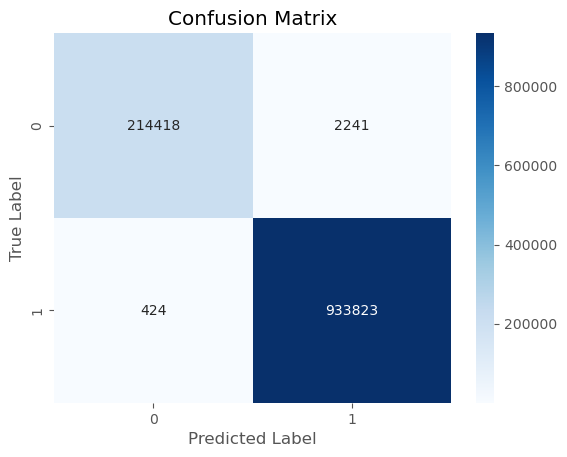

In [ ]:


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, test_predictions)

print('Confusion Matrix:', confusion_matrix(y_test, test_predictions))
print('Classification Report:', classification_report(y_test, test_predictions))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state= 42)
dtc.fit(X_train_stand, y_train_temp)
y_val_pred = dtc.predict(X_val_stand)
accuracy = accuracy_score(y_val, y_val_pred)
print('For Validation set')
print(f"Accuracy: {accuracy}")
print('Precision:', precision_score(y_val, y_val_pred, average='weighted'))
print('Recall:', recall_score(y_val, y_val_pred, average='weighted'))
print('F1-score:', f1_score(y_val, y_val_pred, average='weighted'))
print('R-squared :', r2_score(y_val, y_val_pred))
print('RMSE :', mean_squared_error(y_val, y_val_pred, squared=False))


For Validation set
Accuracy: 0.9953149912460194
Precision: 0.995314532451514
Recall: 0.9953149912460194
F1-score: 0.9953147580099057
R-squared : 0.9692922287907584
RMSE : 0.06844712378165034


In [ ]:
# Evaluate the model on the testing data
test_predictions = dtc.predict(X_test_stand)
accuracy = accuracy_score(y_test, test_predictions)
print('For test set')
print(f"Accuracy: {accuracy}")
print('Precision:', precision_score(y_test, test_predictions, average='weighted'))
print('Recall:', recall_score(y_test, test_predictions, average='weighted'))
print('F1-score:', f1_score(y_test, test_predictions, average='weighted'))
print('R-squared score :', r2_score(y_test, test_predictions))
print('RMSE :', mean_squared_error(y_test, test_predictions, squared=False))


For test set
Accuracy: 0.9952811089698029
Precision: 0.995280967469734
Recall: 0.9952811089698029
F1-score: 0.995281037866631
R-squared score : 0.96911972133942
RMSE : 0.06869418483537802


Confusion Matrix: [[213935   2724]
 [  2707 931540]]
Classification Report:               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    216659
         1.0       1.00      1.00      1.00    934247

    accuracy                           1.00   1150906
   macro avg       0.99      0.99      0.99   1150906
weighted avg       1.00      1.00      1.00   1150906



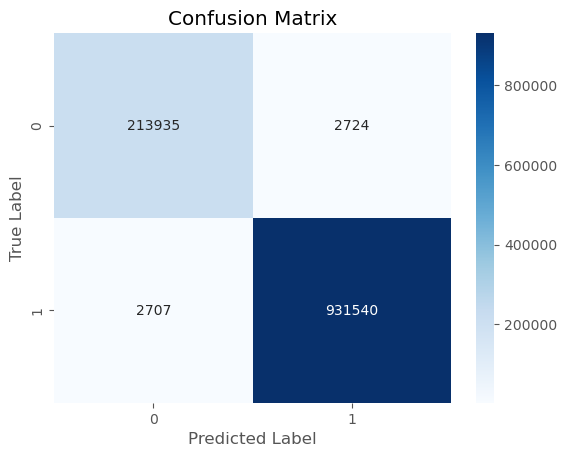

In [ ]:


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, test_predictions)

print('Confusion Matrix:', confusion_matrix(y_test, test_predictions))
print('Classification Report:', classification_report(y_test, test_predictions))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression


LR = LogisticRegression(random_state=42).fit(X_train_stand, y_train_temp)
y_val_pred = LR.predict(X_val_stand)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")
print('Precision:', precision_score(y_val, y_val_pred, average='weighted'))
print('Recall:', recall_score(y_val, y_val_pred, average='weighted'))
print('F1-score:', f1_score(y_val, y_val_pred, average='weighted'))
print('R-squared score:', r2_score(y_val, y_val_pred))
print('RMSE :', mean_squared_error(y_val, y_val_pred, squared=False))



Accuracy: 0.8121365360303413
Precision: 0.6595734256042345
Recall: 0.8121365360303413
F1-score: 0.7279473416527622
R-squared score for id prediction: -0.23134631610974776
RMSE for id prediction: 0.4334321907399803


In [ ]:
test_predictions = LR.predict(X_test_stand)
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy}")
print('Precision:', precision_score(y_test, test_predictions, average='weighted'))
print('Recall:', recall_score(y_test, test_predictions, average='weighted'))
print('F1-score:', f1_score(y_test, test_predictions, average='weighted'))
print('R-squared :', r2_score(y_test, test_predictions))
print('RMSE :', mean_squared_error(y_test, test_predictions, squared=False))


Accuracy: 0.811745702950545
Precision: 0.6589361976470958
Recall: 0.811745702950545
F1-score: 0.7274022026669921
R-squared score for id prediction: -0.23193036557489077
RMSE for id prediction: 0.433882814881455


Confusion Matrix: [[     0 216659]
 [     4 934243]]
Classification Report:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    216659
         1.0       0.81      1.00      0.90    934247

    accuracy                           0.81   1150906
   macro avg       0.41      0.50      0.45   1150906
weighted avg       0.66      0.81      0.73   1150906



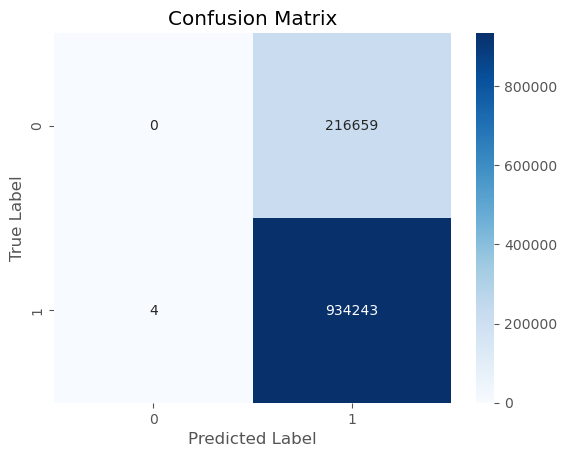

In [ ]:
cm = confusion_matrix(y_test, test_predictions)
print('Confusion Matrix:', confusion_matrix(y_test, test_predictions))
print('Classification Report:', classification_report(y_test, test_predictions))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB().fit(X_train_stand, y_train_temp)
y_val_pred = GNB.predict(X_val_stand)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")
print('Precision:', precision_score(y_val, y_val_pred, average='weighted'))
print('Recall:', recall_score(y_val, y_val_pred, average='weighted'))
print('F1-score:', f1_score(y_val, y_val_pred, average='weighted'))
print('R-squared score:', r2_score(y_val, y_val_pred))
print('RMSE:', mean_squared_error(y_val, y_val_pred, squared=False))



Accuracy: 0.8067112402848193
Precision: 0.7227254465797439
Recall: 0.8067112402848193
F1-score: 0.7342039915905089
R-squared score: -0.2669062796539807
RMSE: 0.4396461755948534


In [ ]:
test_predictions = GNB.predict(X_test_stand)
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy}")
print('Precision:', precision_score(y_test, test_predictions, average='weighted'))
print('Recall:', recall_score(y_test, test_predictions, average='weighted'))
print('F1-score:', f1_score(y_test, test_predictions, average='weighted'))
print('R-squared score:', r2_score(y_test, test_predictions))
print('RMSE:', mean_squared_error(y_test, test_predictions, squared=False))

Accuracy: 0.8063334451293155
Precision: 0.7219135179260512
Recall: 0.8063334451293155
F1-score: 0.7335414235626521
R-squared score: -0.26734801532203734
RMSE: 0.44007562403601097


Confusion Matrix: [[  5800 210859]
 [ 12033 922214]]
Classification Report:               precision    recall  f1-score   support

         0.0       0.33      0.03      0.05    216659
         1.0       0.81      0.99      0.89    934247

    accuracy                           0.81   1150906
   macro avg       0.57      0.51      0.47   1150906
weighted avg       0.72      0.81      0.73   1150906



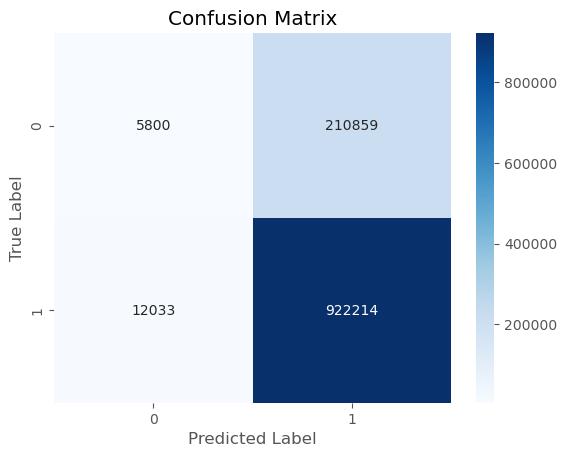

In [ ]:
cm = confusion_matrix(y_test, test_predictions)

print('Confusion Matrix:', confusion_matrix(y_test, test_predictions))
print('Classification Report:', classification_report(y_test, test_predictions))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ADA = AdaBoostClassifier().fit(X_train_stand, y_train_temp)
ADA_predict = ADA.predict(X_val_stand)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")
print('Precision:', precision_score(y_val, y_val_pred, average='weighted'))
print('Recall:', recall_score(y_val, y_val_pred, average='weighted'))
print('F1-score:', f1_score(y_val, y_val_pred, average='weighted'))
print('R-squared score:', r2_score(y_val, y_val_pred))
print('RMSE:', mean_squared_error(y_val, y_val_pred, squared=False))



Accuracy: 0.8067112402848193
Precision: 0.7227254465797439
Recall: 0.8067112402848193
F1-score: 0.7342039915905089
R-squared score: -0.2669062796539807
RMSE: 0.4396461755948534


In [ ]:
test_predictions = ADA.predict(X_test_stand)
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy}")
print('Precision ', precision_score(y_test, test_predictions, average='weighted'))
print('Recall ', recall_score(y_test, test_predictions, average='weighted'))
print('F1-score ', f1_score(y_test, test_predictions, average='weighted'))
print('R-squared ', r2_score(y_test, test_predictions))
print('RMSE ', mean_squared_error(y_test, test_predictions, squared=False))

Accuracy: 0.847555751729507
Precision  0.831266431121774
Recall  0.847555751729507
F1-score  0.8259992149268054
R-squared  0.002409499038834473
RMSE  0.39044109449505054


Confusion Matrix: [[ 74182 142477]
 [ 32972 901275]]
Classification Report:               precision    recall  f1-score   support

         0.0       0.69      0.34      0.46    216659
         1.0       0.86      0.96      0.91    934247

    accuracy                           0.85   1150906
   macro avg       0.78      0.65      0.68   1150906
weighted avg       0.83      0.85      0.83   1150906



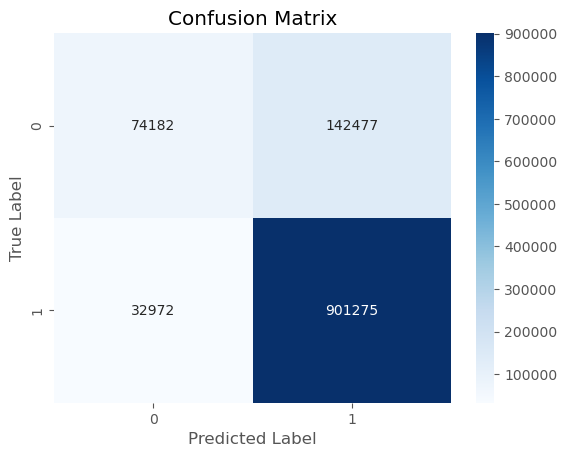

In [ ]:
cm = confusion_matrix(y_test, test_predictions)
print('Confusion Matrix:', confusion_matrix(y_test, test_predictions))
print('Classification Report:', classification_report(y_test, test_predictions))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
